## Projet 5 : Ségmentation des clients d'une base de données d'une plateforme E-commerce Olist

But du projet: segmentation des clients afin de comprendre les différents types d’utilisateurs
fournir à l’équipe marketing une description actionable et proposer contrat de maintenance du Modèle

Approche: utilisation de méthodes non supervisées pour regrouper ensemble des clients de profils similaires
évaluer la fréquence à laquelle la segmentation doit être mise à jour afin de proposer un devis de contrat de maintenance.

Notebook 1 du projet 5:
Dans ce notebook nous allons:

I) Analyser les datasets

    1) Importer les données
    2) Visualiser les premieres lignes des datasets
     
II) Joindre les differents datasets

    1) Renommer les colonnes concernant les zip codes dans les differents datasets
    2) Supprimer les duplicats
    3) Jointure des datasets "client"
    4) Jointure finale avec datasets "produits"
    
III) Feature engineering

    1) Manipulation des features temporels
    2) Création de catégories plus simples 
    3) Aggregation par clients et création de nouvelles colonnes
    4) Jointure des features crées en une seule dataframe ' data'
    
    
IV) Analyse exploratoire

    1) Visualisation des Etats qui achètent le plus
    2) Les produits les plus vendus
    3) L'évolution de la vente en fonction des mois de l'année
    4) Représentation géographique de la consommation par les clients

    
V) Data preprocessing 

    1) Visualisation de la corrélation linéaire entre les différents features
    2) Vérification de valeurs manquates et imputation par les valeurs modales
    3) Suppresion de features redondantes et Encodage des variables categorielle
    4) Sélection des features les plus intéressants selon la variance
    5) Positiver les valeurs
    6) Train/Test split
    

    
Le code fourni drespectera la convention PEP8 pour être utilisable par Olist.


In [132]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#import missingno as msno
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

I) Analyser les datasets

    1) Importer les données
   

In [5]:
customers_data = pd.read_csv('olist_customers_dataset.csv')
geolocation_data = pd.read_csv('olist_geolocation_dataset.csv')
order_items_data = pd.read_csv("olist_order_items_dataset.csv")
payments_data = pd.read_csv('olist_order_payments_dataset.csv')
order_review_data = pd.read_csv("olist_order_reviews_dataset.csv")
orders_data = pd.read_csv('olist_orders_dataset.csv')
products_data = pd.read_csv("olist_products_dataset.csv")
sellers_data = pd.read_csv("datasets_55151_195341_olist_sellers_dataset (1).csv")
product_category = pd.read_csv('product_category_name_translation.csv')


    2) Visualiser les premieres lignes des datasets

In [ ]:
customers_data.head(2)

In [ ]:
orders_data.head(2)

In [ ]:
geolocation_data.head(2)

In [ ]:
order_items_data.head(2)

In [ ]:
payments_data.head(2)  

In [ ]:
order_review_data.head(2)

In [ ]:
orders_data.head(2)

In [ ]:
products_data.head(2)

In [ ]:
sellers_data.head(2)

In [ ]:
product_category.head(2)

In [57]:
datasets = [customers_data, orders_data, geolocation_data, order_items_data, payments_data, order_review_data, orders_data, products_data, sellers_data, product_category]
dataset_names = ['customers_data', 'orders_data', 'geolocation_data', 'order_items_data', 'payments_data', 'order_review_data',
                 'orders_data', 'products_data', 'sellers_data', 'product_category']

In [58]:
for dataset_names,dataset in zip(dataset_names, datasets):  
    print('{} {} {} {}'.format('The shape of the', dataset_names, 'is', dataset.shape))

The shape of the customers_data is (99441, 5)
The shape of the orders_data is (99441, 8)
The shape of the geolocation_data is (1000163, 5)
The shape of the order_items_data is (112650, 7)
The shape of the payments_data is (103886, 5)
The shape of the order_review_data is (100000, 7)
The shape of the orders_data is (99441, 8)
The shape of the products_data is (32951, 9)
The shape of the sellers_data is (3095, 4)
The shape of the product_category is (71, 2)


II) Joindre les differents datasets

    1) Renommer les colonnes concernant les zip codes dans les differents datasets
    2) Supprimer les duplicats
    3) Jointure des datasets "client"
    4) Jointure finale avec datasets "produits"

1) Renommer les colonnes concernant les zip codes dans les differents datasets

In [5]:
#renommer les colonnes concernant les zip codes dans les tables pour pouvoir l'utiliser comme une clé pour l'aggrégation
geolocation_data.rename(columns={'geolocation_zip_code_prefix':'zip_code_prefix'},inplace=True)
customers_data.rename(columns={'customer_zip_code_prefix':'zip_code_prefix'},inplace=True)
sellers_data.rename(columns={'seller_zip_code_prefix':'zip_code_prefix'},inplace=True)

2) Supprimer les duplicats

In [6]:
geolocation_data.drop_duplicates(subset='zip_code_prefix',inplace=True)
geolocation_data.shape

(19015, 5)

3) Jointure des datasets "client"

In [7]:
    
order = pd.merge(orders_data,order_review_data,how='left', on='order_id')
order = pd.merge(order,payments_data,on='order_id')
order = pd.merge(order,customers_data,on='customer_id')
order = pd.merge(order,order_items_data,on='order_id')

# effectuer une jointure left outer afin de garder toutes les données sur les zipe codes, latitude et longitude
order = pd.merge(order,geolocation_data,how='left',on='zip_code_prefix')
order.shape

(118315, 32)

4) Jointure finale avec datasets "produits"

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [9]:
product = pd.merge(order,products_data,how='left', on='product_id')
product = pd.merge(product,product_category,how = 'left', on='product_category_name')

In [22]:
#product.head()

III) Feature engineering

    1) Manipulation des features temporels
    2) Création de catégories plus simples 
    3) Aggregation par clients et création de nouvelles colonnes
    4) Jointure des features crées en une seule dataframe ' data'
 

1) Manipulation des features temporels

In [10]:
#Formater les colonnes de dates de str en format de date manipulable
    
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    product[col] = pd.to_datetime(product[col], format='%Y-%m-%d %H:%M:%S')

In [11]:
# Month_order pour data exploration
product['Month_order'] = product['order_purchase_timestamp']
product['year_order'] = pd.DatetimeIndex(product['Month_order']).year
product['month_order'] =  pd.DatetimeIndex(product['Month_order']).month
product['purchace_date'] =  product['order_purchase_timestamp'].dt.strftime('%m-%Y')
product['Period'] = product.year_order.astype(str).str.cat(product.month_order.astype(str), sep='/')
product['order_delivered_date'] = product['order_delivered_customer_date'].dt.to_period('M').astype('str')
product['month_delivered'] =  pd.DatetimeIndex(product['order_delivered_date']).month

# Le temps mis entre l'achat d'un produit et sa livraison
product['order_process_time'] = product['order_delivered_customer_date'] - product['order_purchase_timestamp']

# Délais de livraison de produits aux clients en nombre de jours
product['delivery_delay_days'] = product['order_process_time'].dt.days

# Calculer le différence en temps entre la date de livraison prévu et la date réelle de livraison 
product['difference_in_delivery'] = product['order_estimated_delivery_date'] - product['order_delivered_customer_date']
# Afficher la différence en jours seulement
product['difference_delivery_days'] = product['difference_in_delivery'].dt.days

# Si la difference est négative (donc il y a un retard dans la livraison du produit), changer la valeur en 'Late_delivery'
product['difference_delivery_days'].mask(product['difference_delivery_days'] <=0 ,'Late_delivery', inplace=True)


2) Création de catégories plus simples

In [12]:
    
# classer les mois en fonction de la saison

seasons_names_dict = {1 : 'winter',
                      2 : 'winter',
                      12 : 'winter',
                      
                      3 : 'spring',
                      4 : 'spring',
                      5 : 'spring',
                      
                      6 : 'summer',
                      7 : 'summer',
                      8 : 'summer',
                      
                      9 : 'autumn',
                      10 : 'autumn',
                      11 : 'autumn',
    
}

# Remap category to seasons
product['delivery_season']  = product['month_delivered'].replace(seasons_names_dict)  



In [13]:
# Création des catégories plus globales pour les produits 

product_categories_dict = {
    'construction_tools_construction': 'home_$_electonics',
    'construction_tools_lights': 'home_$_electonics',
    'construction_tools_safety': 'home_$_electonics',
    'costruction_tools_garden': 'home_$_electonics',
    'costruction_tools_tools': 'home_$_electonics',
    'garden_tools': 'home_$_electonics',
    'home_construction': 'home_$_electonics',
    'furniture_bedroom': 'home_$_electonics',
    'furniture_decor': 'home_$_electonics',
    'furniture_living_room': 'home_$_electonics',
    'furniture_mattress_and_upholstery': 'home_$_electonics',
    'bed_bath_table': 'home_$_electonics',
    'kitchen_dining_laundry_garden_furniture': 'home_$_electonics',
    'office_furniture': 'home_$_electonics',
    'home_appliances': 'home_$_electonics',
    'home_appliances_2': 'home_$_electonics',
    'home_comfort_2': 'home_$_electonics',
    'home_confort': 'home_$_electonics',
    'air_conditioning': 'home_$_electonics',
    'housewares': 'home_$_electonics',
    'art': 'home_$_electonics',
    'arts_and_craftmanship': 'home_$_electonics',
    'cool_stuff': 'home_$_electonics',

    'electronics': 'home_$_electonics',
    'audio': 'home_$_electonics',
    'tablets_printing_image': 'home_$_electonics',
    'telephony': 'home_$_electonics',
    'fixed_telephony': 'home_$_electonics',
    'small_appliances': 'home_$_electonics',
    'small_appliances_home_oven_and_coffee': 'home_$_electonics',
    'computers_accessories': 'home_$_electonics',
    'computers': 'home_$_electonics',

    'fashio_female_clothing': 'fashion',
    'fashion_bags_accessories': 'fashion',
    'fashion_childrens_clothes': 'fashion',
    'fashion_male_clothing': 'fashion',
    'fashion_shoes': 'fashion',
    'fashion_sport': 'fashion',
    'fashion_underwear_beach': 'fashion',
    'watches_gifts': 'fashion',
    'luggage_accessories' : 'fashion',


    'drinks': 'groceries',
    'food': 'groceries',
    'food_drink': 'groceries',
    'la_cuisine': 'groceries',
    'flowers': 'groceries',

    'health_beauty': 'groceries',
    'perfumery': 'groceries',
    'diapers_and_hygiene': 'groceries',
    'baby': 'groceries',

    'christmas_supplies': 'groceries',
    'stationery': 'groceries',
    'party_supplies': 'groceries',
    'auto': 'groceries',
    
    'sports_leisure': 'leisure',
    'consoles_games': 'leisure',
    'musical_instruments': 'leisure',
    'toys': 'leisure',
    'cine_photo': 'leisure',
    'dvds_blu_ray': 'leisure',
    'cds_dvds_musicals': 'leisure',
    'music': 'leisure',
    'books_general_interest': 'leisure',
    'books_imported': 'leisure',
    'books_technical': 'leisure',

    

    'agro_industry_and_commerce': 'services',
    'industry_commerce_and_business': 'services',
    'security_and_services': 'services',
    'signaling_and_security': 'services',
    'market_place': 'services',
    'pet_shop': 'services',
}

# Remplacer les catégories par les nouelles
product['product_category']  = \
    product['product_category_name_english'] \
    .replace(product_categories_dict)

In [31]:
Region_dict = {
    'AC':'North_region',
    'AM': 'North_region',
    'AP': 'North_region',
    'PA': 'North_region',
    'RO':'North_region', 
    'RR':'North_region',
    'TO': 'North_region',
    'RN': 'North_region',
    
    'MA': 'Northeast_region',
    'CE': 'Northeast_region',
    'RS': 'Northeast_region',
    'PB': 'Northeast_region',
    'PE': 'Northeast_region',
    'AL': 'Northeast_region',
    'SE': 'Northeast_region',
    'BA': 'Northeast_region',
    'PI': 'Northeast_region',

    'MG': 'Southesar_region',
    'SP': 'Southesar_region',
    'RJ' :'Southesar_region',
    'ES':'Southesar_region',
    
    'MS': 'Central_West_region',
    'GO': 'Central_West_region',
    'MS': 'Central_West_region',
    'MT': 'Central_West_region',
    'DF': 'Central_West_region',
    
    'SC': 'South_region',
    'PR': 'South_region',
    'RS': 'South_region', 
}


# Remap category to main category
product['Region']  = \
    product['customer_state'] \
    .replace(Region_dict)


In [14]:
#Transformer les commentaires laissés par les clients en nombre de caractères
product['Comment_Len'] = product['review_comment_message'].astype(str).map(len)

In [15]:
# Savegarder les données
product.to_csv('product.csv', index = False)

In [3]:
product = pd.read_csv('product.csv')

In [4]:
product.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,Period,order_delivered_date,month_delivered,order_process_time,delivery_delay_days,difference_in_delivery,difference_delivery_days,delivery_season,product_category,Comment_Len
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,2017/10,2017-10,10.0,8 days 10:28:40,8.0,7 days 02:34:47,7.0,autumn,home_$_electonics,170
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,2017/10,2017-10,10.0,8 days 10:28:40,8.0,7 days 02:34:47,7.0,autumn,home_$_electonics,170
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,a54f0611adc9ed256b57ede6b6eb5114,4,...,2017/10,2017-10,10.0,8 days 10:28:40,8.0,7 days 02:34:47,7.0,autumn,home_$_electonics,170
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,8d5266042046a06655c8db133d120ba5,4,...,2018/7,2018-08,8.0,13 days 18:46:08,13.0,5 days 08:32:15,5.0,summer,groceries,20
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,e73b67b67587f7644d5bd1a52deb1b01,5,...,2018/8,2018-08,8.0,9 days 09:27:40,9.0,17 days 05:53:31,17.0,summer,groceries,3


In [6]:
product.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_unique_id',
       'zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'Month_order', 'year_order',
    

In [5]:
product.shape

(118315, 55)

In [8]:
product['customer_unique_id'].nunique()

95419

3) Aggregation par clients et création de nouvelles colonnes

In [16]:
# Grouper par les clients uniques 
df_group = product.groupby('customer_unique_id')

In [17]:
# Calcule de nombre de commandes par client
nb_orders_per_customer = df_group['order_id'].nunique().to_frame().reset_index()
# Renommer la colonne 
nb_orders_per_customer.rename(columns={'order_id' : 'nb_orders_per_customer'}, inplace=True)

In [18]:
# Longueur du commentaire laissé par le client
# Pour chaque client on va adittionner le nobre de charactère laissé en commentaire pour chaqu'une de ses commandes (s'il y en a )
Comment_Length = df_group['Comment_Len'].sum().to_frame().round().reset_index() 

In [19]:
# Calculer la moyenne de review_score
review_score= df_group['review_score'].mean().to_frame().reset_index()

In [20]:
#nombre de paiements pour une commande quelque soit le moyen de paiement ( en combien de fois le client a payé)
payment_sequential = df_group['payment_sequential'].count().to_frame().reset_index()

In [21]:
# Le nombre de paiments effectuées par tranches par client unique
# On calcule la valeur moyenne de tranches payés par chaque client
payment_installments= df_group['payment_installments'].mean().to_frame().reset_index()

In [22]:
# La somme d'argent payée par chaque client pour toutes ses commandes
payment_value = df_group['payment_value'].sum().to_frame().reset_index()

In [23]:
delivery_delay_days= df_group['delivery_delay_days'].mean().to_frame().reset_index()

#### Les features suivants sont le résultats de suites d'opérations sur les colones après le regroupement de ces derners par le client unique.
Nous avons fait par étape:

    - relevé les valeurs uniques (unique())
    - mis sous forme de dataframe (to_frame)
    - selectionné la première valeure relevée par unique() car il y 'a plusiers valeurs correspondnates pour le même client et on veut garder la plus pertinenete (plus fréquente)
    - remettre l'indexation à 0 (reset_index())

In [55]:
# Pour un client unique il peut y avoir plusieurs valeurs correspondant à la ville, 
#on va ici récupérer les valeurs uniques ensuite avec la fonction lambda récuperer une seule ville ( en première position)
city = df_group['customer_city'].unique().to_frame().apply(lambda x : [y[0] for y in x]).reset_index()
city.rename(columns={'customer_city': 'city'}, inplace= True)

In [57]:
zip_code = df_group['zip_code_prefix'].unique().to_frame().apply(lambda x :   [y[0] for y in x]).reset_index()
zip_code.rename(columns={'zip_code_prefix':'zip_code'},inplace=True)

In [58]:
state = df_group['customer_state'].unique().to_frame().apply(lambda x :   [y[0] for y in x]).reset_index()
state.rename(columns={'customer_state': 'state'}, inplace = True)

In [32]:
Region = df_group['Region'].unique().to_frame().apply(lambda x :   [y[0] for y in x]).reset_index()

In [59]:
latitude = df_group['geolocation_lat'].unique().to_frame().apply(lambda x :   [y[0] for y in x]).reset_index()
latitude.rename(columns={'geolocation_lat': 'latitude'}, inplace = True)

In [60]:
longitude = df_group['geolocation_lng'].unique().to_frame().apply(lambda x :   [y[0] for y in x]).reset_index()
longitude.rename(columns={'geolocation_lng': 'longitude'}, inplace = True)

In [35]:
product_category = df_group['product_category'].unique().to_frame().apply(lambda x :   [y[0] for y in x]).reset_index()

In [36]:
product_photos_qty = df_group['product_photos_qty'].unique().to_frame().apply(lambda x : [y[0] for y in x]).reset_index()

#### Les features suivants sont le résultats de suites d'opérations sur les colones après le regroupement de ces derniers par le client unique.
Nous avons fait par étape:

    - calculer le nombre de valeurs uniques pour chaque client pour le feature donné dans l'orde decroissant (lambda function)
    - mise sous la forme de dataframe (to_frame)
    - commencer l'indexation de lignes de 0 (reset_index)
    - éliminer les colonnes crées dans le processus , qui ne sont pas nécessaires
    - ou renommer certaines colonnes

In [37]:
# Type de paiement
payment_type = df_group['payment_type'].apply(lambda x:x.value_counts(ascending=False).index[0]).reset_index()

In [62]:
product_category = df_group['product_category'].apply(lambda x:x.value_counts(ascending=False)).to_frame().reset_index().drop(['product_category'], axis = 1)
product_category.rename(columns={'level_1':'product_category'},inplace=True) 

In [39]:
delivery_season= df_group['delivery_season'].apply(lambda x:x.value_counts(ascending=False)).to_frame().reset_index().drop(['delivery_season'], axis= 1)

In [63]:
month_order = df_group['month_order'].apply(lambda x:x.value_counts(ascending=False)).to_frame().reset_index().drop(['month_order'], axis= 1)
month_order.rename(columns={'level_1':'month_order'},inplace=True) 

In [64]:
year_order = df_group['year_order'].apply(lambda x:x.value_counts(ascending=False)).to_frame().reset_index().drop(['year_order'], axis= 1)
year_order.rename(columns={'level_1':'year_order'},inplace=True) 

In [65]:
purchace_date = df_group['purchace_date'].apply(lambda x:x.value_counts(ascending=False)).to_frame().reset_index().drop(['purchace_date'], axis= 1)
purchace_date.rename(columns={'level_1':'purchace_date'},inplace=True) 

In [67]:
# Sauvegarder les features crées
city.to_csv('city.csv', index = False)
state.to_csv('state.csv', index = False)
Region.to_csv('Region.csv', index = False)
zip_code.to_csv('zip_code.csv', index = False)
latitude.to_csv('latitude.csv', index = False)
longitude.to_csv('longitude.csv', index = False)
year_order.to_csv('year_order.csv', index = False)
month_order.to_csv('month_order.csv', index = False)
review_score.to_csv('review_score.csv', index = False)
payment_type.to_csv('payment_type.csv', index = False)
payment_value.to_csv('payment_value.csv', index = False)
purchace_date.to_csv('purchace_date.csv', index = False)
Comment_Length.to_csv('Comment_Length.csv', index = False)
delivery_season.to_csv('delivery_season.csv', index = False)
product_category.to_csv('product_category.csv', index = False)
product_photos_qty.to_csv('product_photos_qty.csv', index = False)
payment_sequential.to_csv('payment_sequential.csv', index = False)
delivery_delay_days.to_csv('delivery_delay_days.csv', index = False)
payment_installments.to_csv('payment_installments.csv', index = False)
nb_orders_per_customer.to_csv('nb_orders_per_customer.csv', index = False)

4) Joindre des features crées en une seule dataframe ' data'

In [196]:
# Fonction pour merger les dataframes
list_of_dataframes_to_merge= [state, city,Region, zip_code, latitude, longitude, year_order, month_order,
                              review_score,payment_type,payment_value, purchace_date,Comment_Length, 
                              delivery_season, product_category, product_photos_qty, payment_sequential, 
                              delivery_delay_days, payment_installments, nb_orders_per_customer]


def dataframes_merger(list_of_dataframes_to_merge):
    """ Cette fonction va merger toutes les dataframes obtenus après l'agrégation par clients"""
    # Jointure des deux premièrs dataframes
    data_merged = pd.merge(list_of_dataframes_to_merge[0], list_of_dataframes_to_merge[1], how='left', on='customer_unique_id')
    
   # Itération sur la liste contenant les noms de dataframes à merger et jointure sur 'customer_unique_id'
    for i in range(2,19):
    
        data_merged = pd.merge(data_merged, list_of_dataframes_to_merge[i], how='left', on='customer_unique_id')
    return data_merged
    print('Daframes merged successfully')

In [197]:
data=dataframes_merger(list_of_dataframes_to_merge)

In [198]:
data.shape

(126527, 20)

In [12]:
data.head()

,customer_unique_id,state,city,Region,zip_code,latitude,longitude,year_order,month_order,review_score,payment_type,payment_value,purchace_date,Comment_Len,delivery_season,product_category,product_photos_qty,payment_sequential,delivery_delay_days,payment_installments
0,0000366f3b9a7992bf8c76cfdf3221e2,SP,cajamar,Southesar_region,7787,-23.335331,-46.828647,2018,5,5.0,credit_card,141.90,05-2018,111,spring,home_$_electonics,1.0,1,6.0,8.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,SP,osasco,Southesar_region,6053,-23.567395,-46.792957,2018,5,4.0,credit_card,27.19,05-2018,3,spring,groceries,1.0,1,3.0,1.0
2,0000f46a3911fa3c0805444483337064,SC,sao jose,South_region,88115,-27.543787,-48.625680,2017,3,3.0,credit_card,86.22,03-2017,3,spring,groceries,3.0,1,25.0,8.0
3,0000f6ccb0745a6a4b88665a16c9f078,PA,belem,North_region,66812,-1.311011,-48.482884,2017,10,4.0,credit_card,43.62,10-2017,12,autumn,home_$_electonics,5.0,1,20.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,SP,sorocaba,Southesar_region,18040,-23.504368,-47.466156,2017,11,5.0,credit_card,196.89,11-2017,3,autumn,home_$_electonics,3.0,1,13.0,6.0


In [203]:
data.rename(columns={'level_1':'delivery_season'},inplace=True) 

In [204]:
# Sauvegarde rla dataframe mergée
data.to_csv('data.csv', index = False)

In [9]:
data = pd.read_csv('./data.csv')

In [11]:
data = data.drop_duplicates(subset=['customer_unique_id'])

In [12]:
data.shape

(95419, 20)

IV) Analyse exploratoire

    1) Visualisation des Etats qui achètent le plus
    2) Les produits les plus vendus
    3) L'évolution de la vente en fonction des mois de l'année
    4) Représentation géographique de la consommation par les clients

1) Visualisation des Etats qui achètent le plus

In [122]:
top_buying_states = data['state'].value_counts().sort_values(ascending=False)[:10]

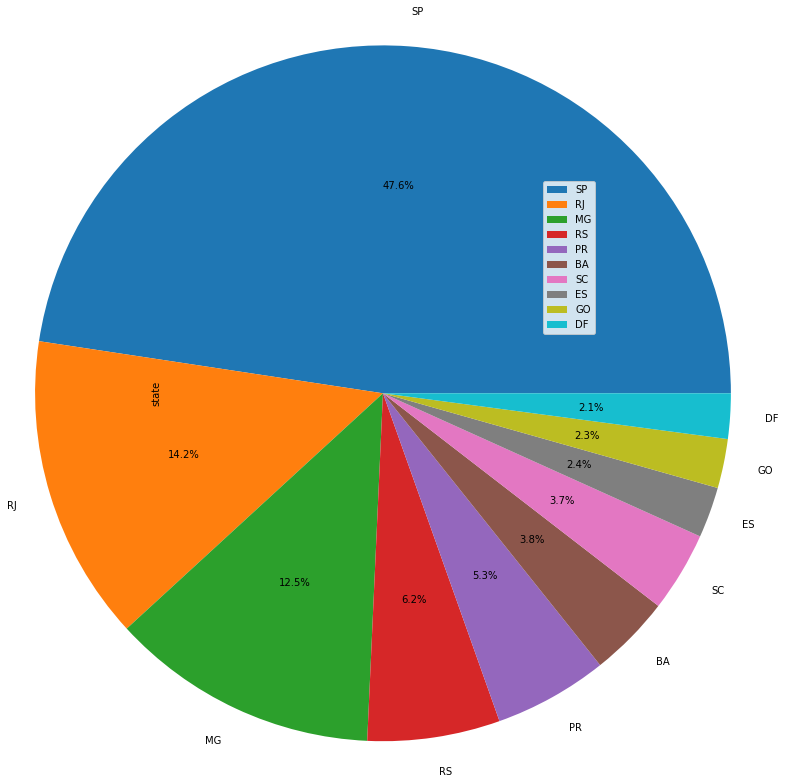

In [123]:
# Les Etats d'ou sont généré le plus d'achats en ligne  
top_buying_states.plot(kind='pie',figsize=(10,8),autopct='%.1f%%',radius=2)
plt.legend()
plt.show()

2) Les produits les plus vendus

Text(0, 0.5, 'Product Name')

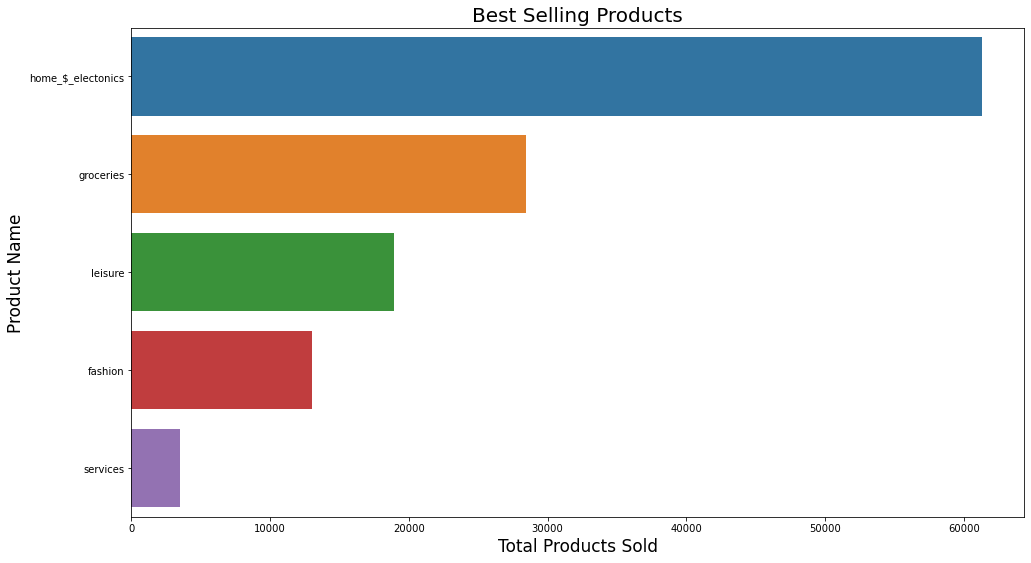

In [124]:
Best_selling_products = data['product_category'].value_counts().sort_values(ascending=False)[:20]

# Visualisation en bar
fig=plt.figure(figsize=(16,9))
sns.barplot(y=Best_selling_products.index,x=Best_selling_products.values)
plt.title('Best Selling Products',fontsize=20)
plt.xlabel('Total Products Sold',fontsize=17)
plt.ylabel('Product Name',fontsize=17)

3) L'évolution de la vente en fonction des mois de l'année

Text(0, 0.5, 'Orders')

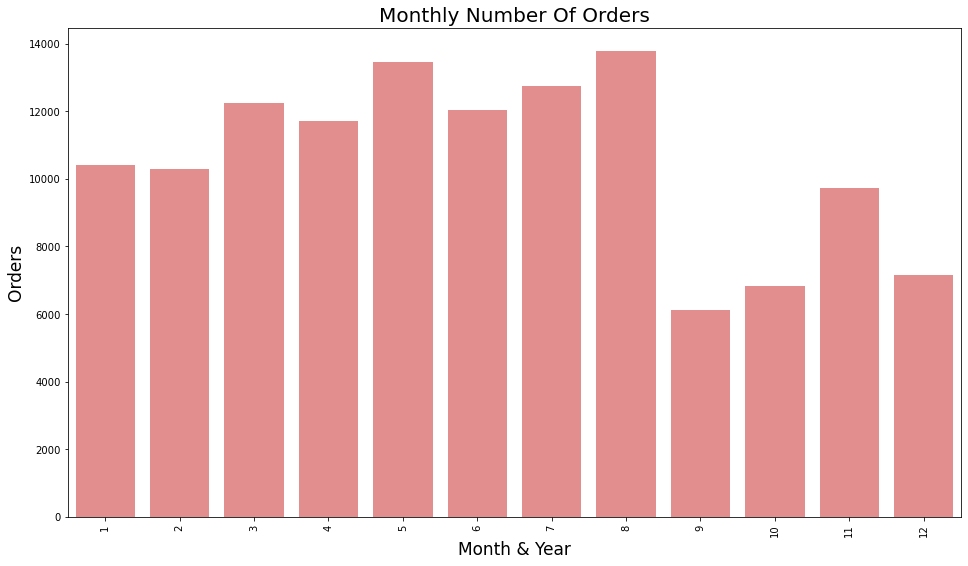

In [125]:
order_count_by_month =data['month_order'].value_counts()

                                                             
                                                             
#Visualisasi
fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index, color="Lightcoral")
plt.title('Monthly Number Of Orders',fontsize=20)
plt.xlabel('Month & Year',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Orders',fontsize=17)

4) Représentation géographique de la consommation par les clients

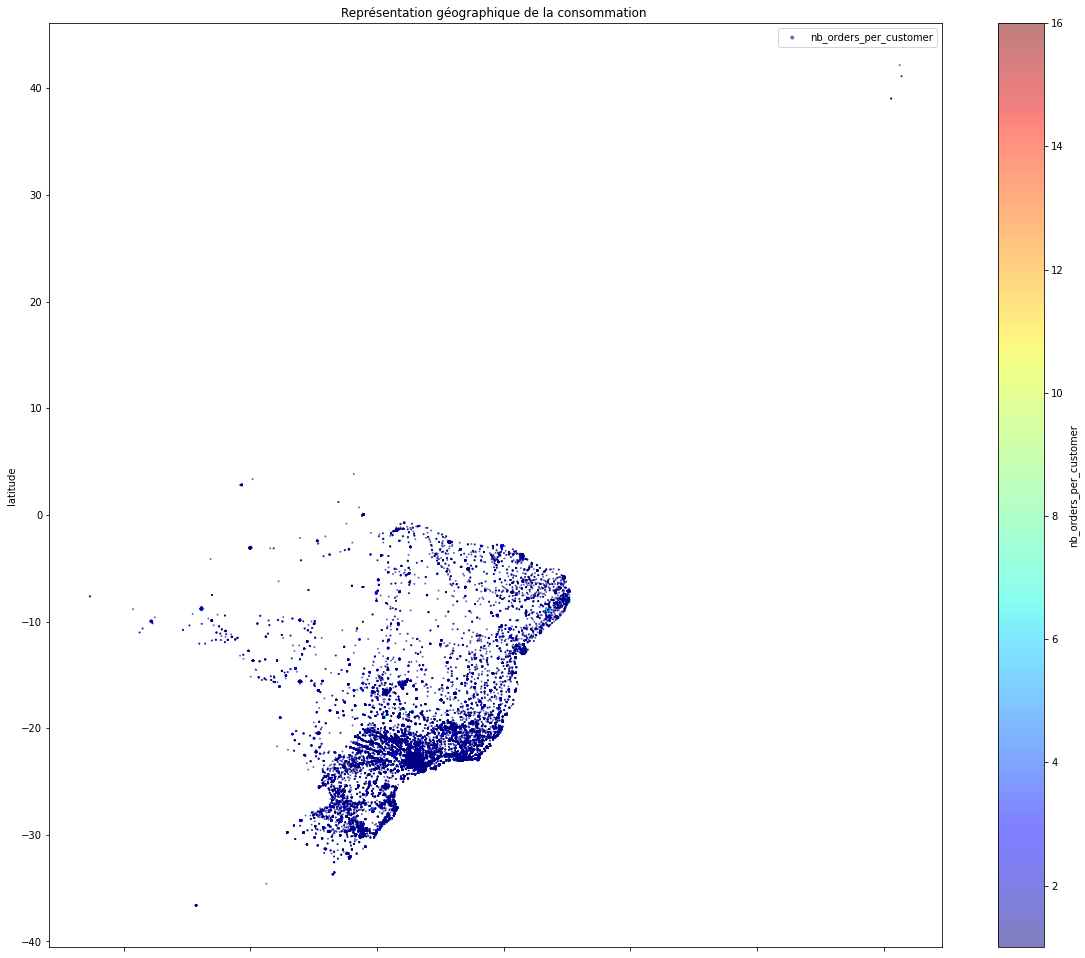

In [126]:
data.plot(kind = "scatter", x = 'longitude', y = 'latitude', alpha = 0.5,
                   s = data['nb_orders_per_customer'], label = 'nb_orders_per_customer', figsize = (20,17),
                  c = 'nb_orders_per_customer', cmap = plt.get_cmap('jet'), colorbar= True, title = 'Représentation géographique de la consommation '
                  )

plt.legend()


V) Data preprocessing pour Machine Learning

    1) Visualisation de la corrélation linéaire pour la sélection de features
    2) Vérification de valeurs manquates et imputation par les valeurs modales
    3) Suppresion de features redondantes et Encodage des variables categorielles
    4) Normaliser les valuers 
    5) Sélection des features les plus intéressants selon la variance

1) Visualisation de la corrélation linéaire pour la sélection de features

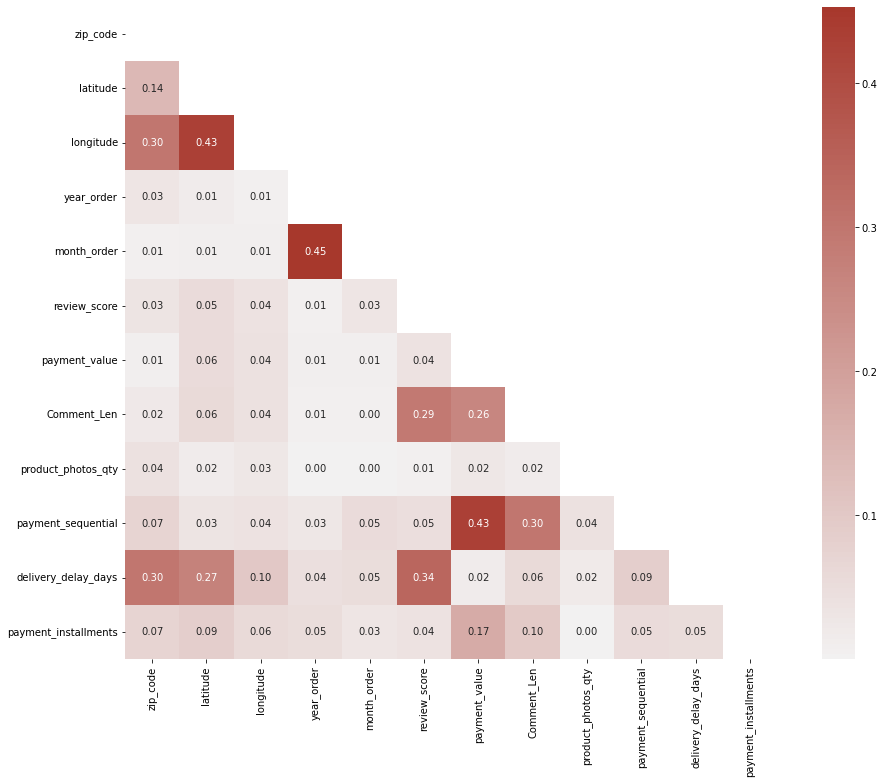

In [205]:
# Représentation en heatmap des corrélations linéaires entre les features de la dataframe = data finale après séléction de meilleurs features
matrix = data.corr().abs()

# Create a mask
plt.figure(figsize=(16,12))

# Création d'une palette de couleurs divergente
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
mask = np.triu(np.ones_like(matrix, dtype=bool))
_ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)


reduced_matrix = matrix.mask(mask)

# This list comprehension finds all other columns that meet the threshold of 0.8. 
to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > 0.8)]

2) Vérification de valeurs manquates et imputation par les valeurs modales

In [206]:
# calculer le nombre de lignes avec des valeurs manquantes

mask = data.isnull().any(axis=1)
rows_w_missing_values = len(data[mask])
rows_w_missing_values_percentage = rows_w_missing_values / 104359 #nb_rows

    # display results
print("")
print("Number of rows with missing values: {} ({:.2%})".format(rows_w_missing_values, rows_w_missing_values_percentage))

    # compute number of columns with missing values
mask = data.isnull().any(axis=0)
cols_w_missing_values = len(data[data.columns[mask]].columns)
cols_w_missing_values_percentage = cols_w_missing_values / 19 #nb_columns

    # display results
print("Number of columns with missing values: {} ({:.2%})".format(cols_w_missing_values, cols_w_missing_values_percentage))


Number of rows with missing values: 4285 (4.11%)
Number of columns with missing values: 6 (31.58%)


In [207]:
data.columns

Index(['customer_unique_id', 'state', 'city', 'Region', 'zip_code', 'latitude',
       'longitude', 'year_order', 'month_order', 'review_score',
       'payment_type', 'payment_value', 'purchace_date', 'Comment_Len',
       'delivery_season', 'product_category', 'product_photos_qty',
       'payment_sequential', 'delivery_delay_days', 'payment_installments'],
      dtype='object')

In [208]:
data.head()

,customer_unique_id,state,city,Region,zip_code,latitude,longitude,year_order,month_order,review_score,payment_type,payment_value,purchace_date,Comment_Len,delivery_season,product_category,product_photos_qty,payment_sequential,delivery_delay_days,payment_installments
0,0000366f3b9a7992bf8c76cfdf3221e2,SP,cajamar,Southesar_region,7787,-23.335331,-46.828647,2018,5,5.0,credit_card,141.90,05-2018,111,spring,home_$_electonics,1.0,1,6.0,8.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,SP,osasco,Southesar_region,6053,-23.567395,-46.792957,2018,5,4.0,credit_card,27.19,05-2018,3,spring,groceries,1.0,1,3.0,1.0
2,0000f46a3911fa3c0805444483337064,SC,sao jose,South_region,88115,-27.543787,-48.625680,2017,3,3.0,credit_card,86.22,03-2017,3,spring,groceries,3.0,1,25.0,8.0
3,0000f6ccb0745a6a4b88665a16c9f078,PA,belem,North_region,66812,-1.311011,-48.482884,2017,10,4.0,credit_card,43.62,10-2017,12,autumn,home_$_electonics,5.0,1,20.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,SP,sorocaba,Southesar_region,18040,-23.504368,-47.466156,2017,11,5.0,credit_card,196.89,11-2017,3,autumn,home_$_electonics,3.0,1,13.0,6.0


<AxesSubplot:>

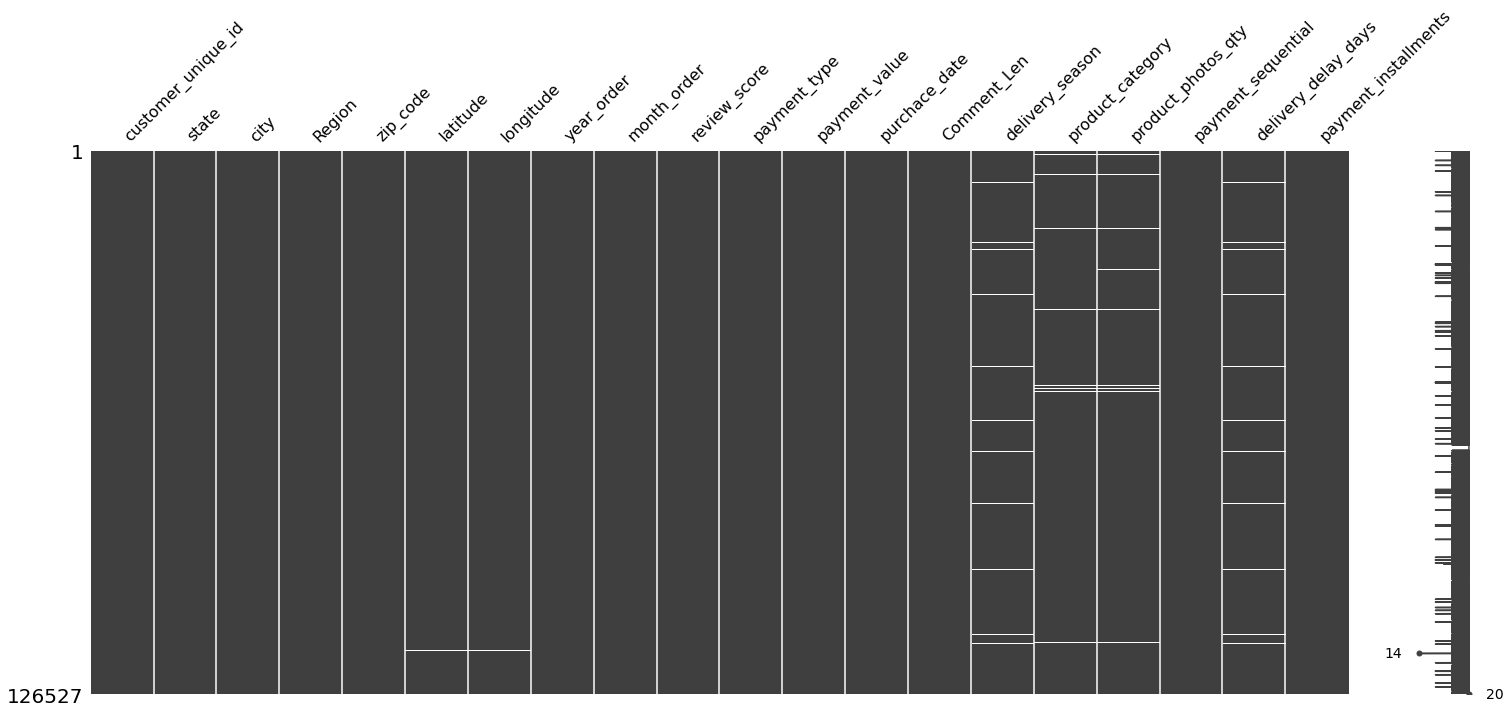

In [209]:
# Visualiser les données manquantes
msno.matrix(data)

In [210]:
# les colonnes  présentent des valeurs nulles, remplassons les par les valeurs modales
cols = data[['delivery_delay_days','product_category','delivery_season', 'product_photos_qty', 'latitude', 'longitude']]

for col in cols.columns:
    mode_data_cols = cols.mode()
    
modes = pd.DataFrame(mode_data_cols)


In [211]:
modes

,delivery_delay_days,product_category,delivery_season,product_photos_qty,latitude,longitude
0,7.0,home_$_electonics,summer,1.0,-23.617639,-46.638981


In [212]:
values = {'delivery_delay_days': 7.0, 'delivery_season' : 'summer', 'product_category' : 'home_$_electonics','product_photos_qty': 1.0,  'latitude': -23.617639,'longitude': -46.638981, }
data = data.fillna(value=values)

3) Suppresion de features redondantes et Encodage des variables categorielles
    

In [13]:
# Pour la partie ML nous allons réduire le dataframe pour garder les informations les plus pertinentes 

prereduced_data = data.drop(['city','state','payment_installments', 'payment_sequential','latitude','longitude', 'zip_code','product_photos_qty', 'month_order', 'year_order' ], axis = 1)

In [14]:
##prereduced_data['purchace_date'] = pd.to_datetime(prereduced_data.purchace_date)

In [15]:
prereduced_data.to_csv('prereduced_data.csv', index = False)

In [17]:
prereduced_data= pd.read_csv('./prereduced_data.csv')

In [18]:
prereduced_data.columns

Index(['customer_unique_id', 'Region', 'review_score', 'payment_type',
       'payment_value', 'purchace_date', 'Comment_Len', 'delivery_season',
       'product_category', 'delivery_delay_days'],
      dtype='object')

In [19]:
prereduced_data['customer_unique_id'].nunique()

95419

In [21]:
len(prereduced_data['purchace_date'])

126527

In [216]:
# Mise sous forme d'index de ces colonnes afin de pouvoir encoder le reste
prereduced_data.set_index(['customer_unique_id', 'purchace_date'], inplace=True)

In [18]:
prereduced_data.head()

,customer_unique_id,Region,review_score,payment_type,payment_value,purchace_date,Comment_Len,delivery_season,product_category,delivery_delay_days
0,0000366f3b9a7992bf8c76cfdf3221e2,Southesar_region,5.0,credit_card,141.90,05-2018,111,spring,home_$_electonics,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Southesar_region,4.0,credit_card,27.19,05-2018,3,spring,groceries,3.0
2,0000f46a3911fa3c0805444483337064,South_region,3.0,credit_card,86.22,03-2017,3,spring,groceries,25.0
3,0000f6ccb0745a6a4b88665a16c9f078,North_region,4.0,credit_card,43.62,10-2017,12,autumn,home_$_electonics,20.0
4,0004aac84e0df4da2b147fca70cf8255,Southesar_region,5.0,credit_card,196.89,11-2017,3,autumn,home_$_electonics,13.0


In [22]:
prereduced_data.columns

Index(['customer_unique_id', 'Region', 'review_score', 'payment_type',
       'payment_value', 'purchace_date', 'Comment_Len', 'delivery_season',
       'product_category', 'delivery_delay_days'],
      dtype='object')

In [45]:
df_unique_clients = pd.DataFrame(prereduced_data['customer_unique_id'])

In [47]:
df_unique_clients.to_csv('df_unique_clients.csv')

In [48]:
df_unique_clients.head()

,customer_unique_id
0,0000366f3b9a7992bf8c76cfdf3221e2
1,0000b849f77a49e4a4ce2b2a4ca5be3f
2,0000f46a3911fa3c0805444483337064
3,0000f6ccb0745a6a4b88665a16c9f078
4,0004aac84e0df4da2b147fca70cf8255


In [218]:
# Encodage des variables catégorielles 
encoded = pd.get_dummies(prereduced_data, columns= ['product_category', 'payment_type', 'Region', 'delivery_season'] )
encoded.reset_index(inplace=True)

In [220]:
# Sauvegarder les données encoded
encoded.to_csv('encoded.csv', index = False)

In [13]:
encoded = pd.read_csv('encoded.csv')

In [219]:
encoded.head()

,customer_unique_id,purchace_date,review_score,payment_value,Comment_Len,delivery_delay_days,product_category_fashion,product_category_groceries,product_category_home_$_electonics,product_category_leisure,product_category_services,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,Region_Central_West_region,Region_North_region,Region_Northeast_region,Region_South_region,Region_Southesar_region,delivery_season_autumn,delivery_season_spring,delivery_season_summer,delivery_season_winter
0,0000366f3b9a7992bf8c76cfdf3221e2,05-2018,5.0,141.90,111,6.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,05-2018,4.0,27.19,3,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
2,0000f46a3911fa3c0805444483337064,03-2017,3.0,86.22,3,25.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,10-2017,4.0,43.62,12,20.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,11-2017,5.0,196.89,3,13.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0


4) Normaliser les valuers

In [221]:
# Mise sous forme d'index de ces colonnes afin de pouvoir encoder le reste
encoded.set_index(['customer_unique_id', 'purchace_date'], inplace=True)

In [224]:
df_normalisé = (encoded - encoded.mean()) / (encoded.max() - encoded.min())

In [222]:
# Normaliser les valuers afin d'uniformiser les variances

import pandas as pd
from sklearn import preprocessing

x = encoded.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled_encoded = pd.DataFrame(x_scaled)

In [242]:
df_normalisé.shape

(126527, 22)

In [225]:
df_normalisé.head()

,,review_score,payment_value,Comment_Len,delivery_delay_days,product_category_fashion,product_category_groceries,product_category_home_$_electonics,product_category_leisure,product_category_services,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,Region_Central_West_region,Region_North_region,Region_Northeast_region,Region_South_region,Region_Southesar_region,delivery_season_autumn,delivery_season_spring,delivery_season_summer,delivery_season_winter
customer_unique_id,purchace_date,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,05-2018,0.214824,-0.001500,0.012192,-0.027352,-0.103061,-0.224695,0.505094,-0.149486,-0.027852,-0.18924,0.231279,-0.013602,-0.028437,-0.05421,-0.023521,-0.090985,-0.137346,0.306061,-0.149794,0.702309,-0.336244,-0.21627
0000b849f77a49e4a4ce2b2a4ca5be3f,05-2018,-0.035176,-0.002549,-0.010521,-0.041706,-0.103061,0.775305,-0.494906,-0.149486,-0.027852,-0.18924,0.231279,-0.013602,-0.028437,-0.05421,-0.023521,-0.090985,-0.137346,0.306061,-0.149794,0.702309,-0.336244,-0.21627
0000f46a3911fa3c0805444483337064,03-2017,-0.285176,-0.002009,-0.010521,0.063557,-0.103061,0.775305,-0.494906,-0.149486,-0.027852,-0.18924,0.231279,-0.013602,-0.028437,-0.05421,-0.023521,-0.090985,0.862654,-0.693939,-0.149794,0.702309,-0.336244,-0.21627
0000f6ccb0745a6a4b88665a16c9f078,10-2017,-0.035176,-0.002399,-0.008628,0.039633,-0.103061,-0.224695,0.505094,-0.149486,-0.027852,-0.18924,0.231279,-0.013602,-0.028437,-0.05421,0.976479,-0.090985,-0.137346,-0.693939,0.850206,-0.297691,-0.336244,-0.21627
0004aac84e0df4da2b147fca70cf8255,11-2017,0.214824,-0.000997,-0.010521,0.006141,-0.103061,-0.224695,0.505094,-0.149486,-0.027852,-0.18924,0.231279,-0.013602,-0.028437,-0.05421,-0.023521,-0.090985,-0.137346,0.306061,0.850206,-0.297691,-0.336244,-0.21627


5) Sélection des features les plus intéressants selon la variance

In [244]:
# Afficher les variance de chaque variable de la plus petite à la plus grande
df_normalisé.var(axis=0).sort_values()

payment_value                         0.000041
Comment_Len                           0.000463
delivery_delay_days                   0.001778
payment_type_debit_card               0.013417
Region_North_region                   0.022968
product_category_services             0.027076
payment_type_voucher                  0.027628
Region_Central_West_region            0.051271
Region_Northeast_region               0.082707
product_category_fashion              0.092440
review_score                          0.098442
Region_South_region                   0.118483
product_category_leisure              0.127141
delivery_season_autumn                0.127357
payment_type_boleto                   0.153430
delivery_season_winter                0.169499
product_category_groceries            0.174209
payment_type_credit_card              0.177790
delivery_season_spring                0.209073
Region_Southesar_region               0.212389
delivery_season_summer                0.223186
product_categ

In [245]:
# Transformer de Sklearn pour faire la seléction de variables
# Les variables dont la variance est supérieure à un seuil sont affichés comme 'True'

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.05)
selector.fit_transform(df_normalisé)
selector.get_support()

array([ True, False, False, False,  True,  True,  True,  True, False,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True])

In [246]:
# Extraction des noms de colonnes correspondant aux valeurs 'True'
np.array(df_normalisé.columns)[selector.get_support()]

array(['review_score', 'product_category_fashion',
       'product_category_groceries', 'product_category_home_$_electonics',
       'product_category_leisure', 'payment_type_boleto',
       'payment_type_credit_card', 'Region_Central_West_region',
       'Region_Northeast_region', 'Region_South_region',
       'Region_Southesar_region', 'delivery_season_autumn',
       'delivery_season_spring', 'delivery_season_summer',
       'delivery_season_winter'], dtype=object)

In [247]:
reduced_df_cols = np.array(df_normalisé.columns)[selector.get_support()]

In [248]:
final_data = df_normalisé[reduced_df_cols]

In [249]:
final_data.shape

(126527, 15)

In [250]:
final_data.head()

,,review_score,product_category_fashion,product_category_groceries,product_category_home_$_electonics,product_category_leisure,payment_type_boleto,payment_type_credit_card,Region_Central_West_region,Region_Northeast_region,Region_South_region,Region_Southesar_region,delivery_season_autumn,delivery_season_spring,delivery_season_summer,delivery_season_winter
customer_unique_id,purchace_date,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,05-2018,0.214824,-0.103061,-0.224695,0.505094,-0.149486,-0.18924,0.231279,-0.05421,-0.090985,-0.137346,0.306061,-0.149794,0.702309,-0.336244,-0.21627
0000b849f77a49e4a4ce2b2a4ca5be3f,05-2018,-0.035176,-0.103061,0.775305,-0.494906,-0.149486,-0.18924,0.231279,-0.05421,-0.090985,-0.137346,0.306061,-0.149794,0.702309,-0.336244,-0.21627
0000f46a3911fa3c0805444483337064,03-2017,-0.285176,-0.103061,0.775305,-0.494906,-0.149486,-0.18924,0.231279,-0.05421,-0.090985,0.862654,-0.693939,-0.149794,0.702309,-0.336244,-0.21627
0000f6ccb0745a6a4b88665a16c9f078,10-2017,-0.035176,-0.103061,-0.224695,0.505094,-0.149486,-0.18924,0.231279,-0.05421,-0.090985,-0.137346,-0.693939,0.850206,-0.297691,-0.336244,-0.21627
0004aac84e0df4da2b147fca70cf8255,11-2017,0.214824,-0.103061,-0.224695,0.505094,-0.149486,-0.18924,0.231279,-0.05421,-0.090985,-0.137346,0.306061,0.850206,-0.297691,-0.336244,-0.21627


In [251]:
final_data.to_csv('encoded.csv', index = False)

In [3]:
final_data = pd.read_csv('./encoded.csv')

    5.  Positiver les valeurs

In [4]:
from numpy import clip
for value in final_data:
    # clip pixel values to the range [-1,1] this will positive the negative values (values smaller than -1 will become -1 and values larger than 1 become 1)
    processed_data = clip(final_data, -1.0, 1.0)
    # rescale the values from [-1,1] to [0,1] with 0.5 mean
    processed_data = (processed_data + 1.0) / 2.0

In [6]:
processed_data.to_csv('processed_data.csv', index = False)

In [5]:
processed_data.head()

,review_score,product_category_fashion,product_category_groceries,product_category_home_$_electonics,product_category_leisure,payment_type_boleto,payment_type_credit_card,Region_Central_West_region,Region_Northeast_region,Region_South_region,Region_Southesar_region,delivery_season_autumn,delivery_season_spring,delivery_season_summer,delivery_season_winter
0,0.607412,0.448469,0.387652,0.752547,0.425257,0.40538,0.615639,0.472895,0.454508,0.431327,0.653031,0.425103,0.851154,0.331878,0.391865
1,0.482412,0.448469,0.887652,0.252547,0.425257,0.40538,0.615639,0.472895,0.454508,0.431327,0.653031,0.425103,0.851154,0.331878,0.391865
2,0.357412,0.448469,0.887652,0.252547,0.425257,0.40538,0.615639,0.472895,0.454508,0.931327,0.153031,0.425103,0.851154,0.331878,0.391865
3,0.482412,0.448469,0.387652,0.752547,0.425257,0.40538,0.615639,0.472895,0.454508,0.431327,0.153031,0.925103,0.351154,0.331878,0.391865
4,0.607412,0.448469,0.387652,0.752547,0.425257,0.40538,0.615639,0.472895,0.454508,0.431327,0.653031,0.925103,0.351154,0.331878,0.391865


 6. Train/Test split

In [258]:
from sklearn.model_selection import train_test_split
# Séparer les données en train and test
X_train, X_test= train_test_split(processed_data, test_size=0.3,random_state=0)

X_train.shape, X_test.shape

((88568, 15), (37959, 15))

In [259]:
# Sauvegarder X_train et X_test
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

Dans ce notebook nous avons effectuées toute la partie préalable au Machine Learning pour le traitement des données